In [2]:
import torch

<https://rockt.github.io/2018/04/30/einsum>

    def einsum(*args: Any) -> Tensor:
    r"""einsum(equation, *operands) -> Tensor

    Sums the product of the elements of the input :attr:`operands` along dimensions specified using a notation
    based on the Einstein summation convention.

    Einsum allows computing many common multi-dimensional linear algebraic array operations by representing them
    in a short-hand format based on the Einstein summation convention, given by :attr:`equation`. The details of
    this format are described below, but the general idea is to label every dimension of the input :attr:`operands`
    with some subscript and define which subscripts are part of the output. The output is then computed by summing
    the product of the elements of the :attr:`operands` along the dimensions whose subscripts are not part of the
    output. For example, matrix multiplication can be computed using einsum as `torch.einsum("ij,jk->ik", A, B)`.
    Here, j is the summation subscript and i and k the output subscripts (see section below for more details on why).

    Equation:

        The :attr:`equation` string specifies the subscripts (letters in `[a-zA-Z]`) for each dimension of
        the input :attr:`operands` in the same order as the dimensions, separating subcripts for each operand by a
        comma (','), e.g. `'ij,jk'` specify subscripts for two 2D operands. The dimensions labeled with the same subscript
        must be broadcastable, that is, their size must either match or be `1`. The exception is if a subscript is
        repeated for the same input operand, in which case the dimensions labeled with this subscript for this operand
        must match in size and the operand will be replaced by its diagonal along these dimensions. The subscripts that
        appear exactly once in the :attr:`equation` will be part of the output, sorted in increasing alphabetical order.
        The output is computed by multiplying the input :attr:`operands` element-wise, with their dimensions aligned based
        on the subscripts, and then summing out the dimensions whose subscripts are not part of the output.

        Optionally, the output subscripts can be explicitly defined by adding an arrow ('->') at the end of the equation
        followed by the subscripts for the output. For instance, the following equation computes the transpose of a
        matrix multiplication: 'ij,jk->ki'. The output subscripts must appear at least once for some input operand and
        at most once for the output.

        Ellipsis ('...') can be used in place of subscripts to broadcast the dimensions covered by the ellipsis.
        Each input operand may contain at most one ellipsis which will cover the dimensions not covered by subscripts,
        e.g. for an input operand with 5 dimensions, the ellipsis in the equation `'ab...c'` cover the third and fourth
        dimensions. The ellipsis does not need to cover the same number of dimensions across the :attr:`operands` but the
        'shape' of the ellipsis (the size of the dimensions covered by them) must broadcast together. If the output is not
        explicitly defined with the arrow ('->') notation, the ellipsis will come first in the output (left-most dimensions),
        before the subscript labels that appear exactly once for the input operands. e.g. the following equation implements
        batch matrix multiplication `'...ij,...jk'`.

        A few final notes: the equation may contain whitespaces between the different elements (subscripts, ellipsis,
        arrow and comma) but something like `'. . .'` is not valid. An empty string `''` is valid for scalar operands.

    .. note::

        ``torch.einsum`` handles ellipsis ('...') differently from NumPy in that it allows dimensions
        covered by the ellipsis to be summed over, that is, ellipsis are not required to be part of the output.

    .. note::

        This function does not optimize the given expression, so a different formula for the same computation may
        run faster or consume less memory. Projects like opt_einsum (https://optimized-einsum.readthedocs.io/en/stable/)
        can optimize the formula for you.

    .. note::

        As of PyTorch 1.10 :func:`torch.einsum` also supports the sublist format (see examples below). In this format,
        subscripts for each operand are specified by sublists, list of integers in the range [0, 52). These sublists
        follow their operands, and an extra sublist can appear at the end of the input to specify the output's
        subscripts., e.g. `torch.einsum(op1, sublist1, op2, sublist2, ..., [subslist_out])`. Python's `Ellipsis` object
        may be provided in a sublist to enable broadcasting as described in the Equation section above.

    Args:
        equation (str): The subscripts for the Einstein summation.
        operands (List[Tensor]): The tensors to compute the Einstein summation of.

    Examples::

        >>> # trace
        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> torch.einsum('ii', torch.randn(4, 4))
        tensor(-1.2104)

        >>> # diagonal
        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> torch.einsum('ii->i', torch.randn(4, 4))
        tensor([-0.1034,  0.7952, -0.2433,  0.4545])

        >>> # outer product
        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> x = torch.randn(5)
        >>> y = torch.randn(4)
        >>> torch.einsum('i,j->ij', x, y)
        tensor([[ 0.1156, -0.2897, -0.3918,  0.4963],
                [-0.3744,  0.9381,  1.2685, -1.6070],
                [ 0.7208, -1.8058, -2.4419,  3.0936],
                [ 0.1713, -0.4291, -0.5802,  0.7350],
                [ 0.5704, -1.4290, -1.9323,  2.4480]])

        >>> # batch matrix multiplication
        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> As = torch.randn(3,2,5)
        >>> Bs = torch.randn(3,5,4)
        >>> torch.einsum('bij,bjk->bik', As, Bs)
        tensor([[[-1.0564, -1.5904,  3.2023,  3.1271],
                [-1.6706, -0.8097, -0.8025, -2.1183]],

                [[ 4.2239,  0.3107, -0.5756, -0.2354],
                [-1.4558, -0.3460,  1.5087, -0.8530]],

                [[ 2.8153,  1.8787, -4.3839, -1.2112],
                [ 0.3728, -2.1131,  0.0921,  0.8305]]])

        >>> # with sublist format and ellipsis
        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> torch.einsum(As, [..., 0, 1], Bs, [..., 1, 2], [..., 0, 2])
        tensor([[[-1.0564, -1.5904,  3.2023,  3.1271],
                [-1.6706, -0.8097, -0.8025, -2.1183]],

                [[ 4.2239,  0.3107, -0.5756, -0.2354],
                [-1.4558, -0.3460,  1.5087, -0.8530]],

                [[ 2.8153,  1.8787, -4.3839, -1.2112],
                [ 0.3728, -2.1131,  0.0921,  0.8305]]])

        >>> # batch permute
        >>> A = torch.randn(2, 3, 4, 5)
        >>> torch.einsum('...ij->...ji', A).shape
        torch.Size([2, 3, 5, 4])

        >>> # equivalent to torch.nn.functional.bilinear
        >>> A = torch.randn(3,5,4)
        >>> l = torch.randn(2,5)
        >>> r = torch.randn(2,4)
        >>> torch.einsum('bn,anm,bm->ba', l, A, r)
        tensor([[-0.3430, -5.2405,  0.4494],
                [ 0.3311,  5.5201, -3.0356]])
    """
    # This wrapper exists to support variadic args.
    if len(args) < 2:
        raise ValueError('einsum(): must specify the equation string and at least one operand, '
                         'or at least one operand and its subscripts list')

    equation = None
    operands = None

    if isinstance(args[0], torch.Tensor):
        # Convert the subscript list format which is an interleaving of operand and its subscripts
        # list with an optional output subscripts list at the end (see documentation for more details on this)
        # to the equation string format by creating the equation string from the subscripts list and grouping the
        # input operands into a tensorlist (List[Tensor]).
        def parse_subscript(n: int) -> str:
            if n == Ellipsis:
                return '...'
            if n >= 0 and n < 26:
                return chr(ord('A') + n)
            if n >= 26 and n < 52:
                return chr(ord('a') + n - 26)
            raise ValueError('einsum(): subscript in subscript list is not within the valid range [0, 52)')

        # Parse subscripts for input operands
        equation = ','.join(''.join(parse_subscript(s) for s in l) for l in args[1::2])

        # Parse optional output subscripts (provided when the number of arguments is odd)
        if len(args) % 2 == 1:
            equation += '->' + ''.join(parse_subscript(s) for s in args[-1])
            operands = args[:-1:2]
        else:
            operands = args[::2]
    else:
        equation = args[0]
        operands = args[1:]

    if has_torch_function(operands):
        return handle_torch_function(einsum, operands, equation, *operands)

    if len(operands) == 1 and isinstance(operands[0], (list, tuple)):
        # the old interface of passing the operands as one list argument
        _operands = operands[0]
        # recurse incase operands contains value that has torch function
        # in the original implementation this line is omitted
        return einsum(equation, *_operands)

    return _VF.einsum(equation, operands)  # type: ignore[attr-defined]"""

In [3]:
from IPython import  display


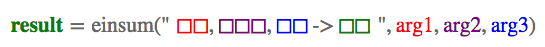

In [4]:
display.Image('../pics/einsum1.png')

# ①矩阵转置

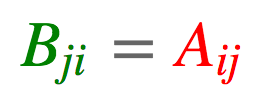

In [5]:
display.Image('../pics/einsum2.png')

In [6]:

a = torch.arange(6).reshape(2, 3)


In [7]:
a

tensor([[0, 1, 2],
        [3, 4, 5]])

In [8]:
torch.einsum('ij->ji', [a])

tensor([[0, 3],
        [1, 4],
        [2, 5]])

# ②求和

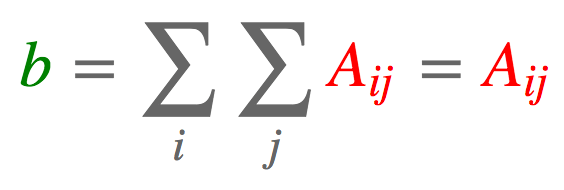

In [9]:
display.Image('../pics/einsum3.png')

In [10]:

a = torch.arange(6).reshape(2, 3)
torch.einsum('ij->', [a])

tensor(15)

# ③列求和

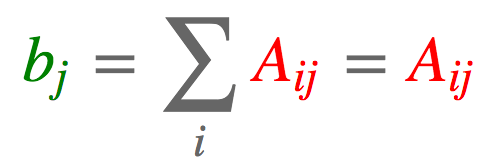

In [11]:
display.Image('../pics/einsum4.png')

In [12]:
a = torch.arange(6).reshape(2, 3)
torch.einsum('ij->j', [a])

tensor([3, 5, 7])

# ④行求和

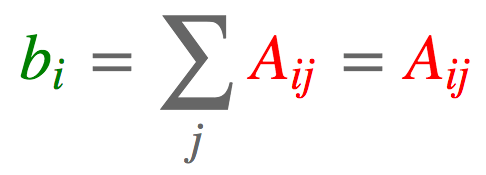

In [13]:
display.Image('../pics/einsum5.png')

In [14]:
a = torch.arange(6).reshape(2, 3)
torch.einsum('ij->i', [a])

tensor([ 3, 12])

# ⑤矩阵-向量相乘

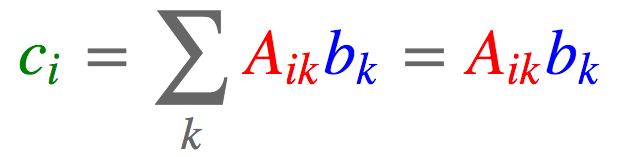

In [15]:
display.Image('../pics/einsum6.jpg')

In [16]:
a = torch.arange(6).reshape(2, 3)
b = torch.arange(3)
print(a)
print(b)
print(torch.einsum('ik,k->i', [a, b]))

tensor([[0, 1, 2],
        [3, 4, 5]])
tensor([0, 1, 2])
tensor([ 5, 14])


# ⑥矩阵-矩阵相乘

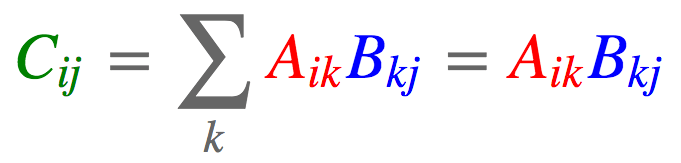

In [17]:
display.Image('../pics/einsum7.png')

In [18]:
a = torch.arange(6).reshape(2, 3)
b = torch.arange(15).reshape(3, 5)
print(a)
print(b)
print(torch.einsum('ik,kj->ij', [a, b]))

tensor([[0, 1, 2],
        [3, 4, 5]])
tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])
tensor([[ 25,  28,  31,  34,  37],
        [ 70,  82,  94, 106, 118]])


# ⑦点积

## 7.1 向量

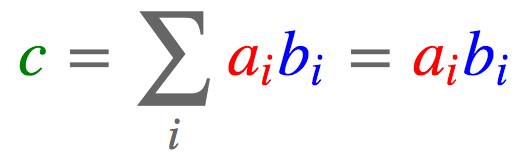

In [19]:
display.Image('../pics/einsum8.png')

In [20]:
a = torch.arange(3)
b = torch.arange(3,6)  # [3, 4, 5]
print(a)
print(b)
print(torch.einsum('i,i->', [a, b]))


tensor([0, 1, 2])
tensor([3, 4, 5])
tensor(14)


## 7.2 矩阵

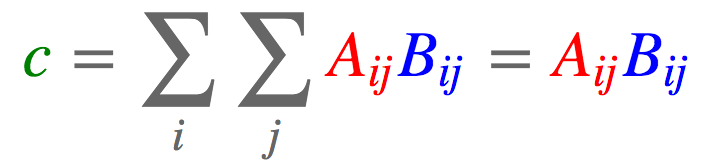

In [21]:
display.Image('../pics/einsum9.jpg')

In [22]:
a = torch.arange(6).reshape(2, 3)
b = torch.arange(6,12).reshape(2, 3)
print(a)
print(b)
print(torch.einsum('ij,ij->', [a, b]))

tensor([[0, 1, 2],
        [3, 4, 5]])
tensor([[ 6,  7,  8],
        [ 9, 10, 11]])
tensor(145)


In [64]:
a = torch.arange(6).reshape(2, 3).float()
b = torch.arange(6,12).reshape(2, 3).float()
print(a)
print(b)
c=torch.einsum('ki,kj->ij',a,b).float()
e=torch.einsum('ik,jk->ij',a,b).float()

print(c)
print(e)
f=torch.einsum('ik,kj->ij',a,b.T).float()
print(f)


tensor([[0., 1., 2.],
        [3., 4., 5.]])
tensor([[ 6.,  7.,  8.],
        [ 9., 10., 11.]])
tensor([[27., 30., 33.],
        [42., 47., 52.],
        [57., 64., 71.]])
tensor([[ 23.,  32.],
        [ 86., 122.]])
tensor([[ 23.,  32.],
        [ 86., 122.]])


In [61]:
print(torch.mm(a,b.T))
print(torch.mm(a.T,b))
print(c.softmax(dim=-1))

tensor([[ 23.,  32.],
        [ 86., 122.]])
tensor([[27., 30., 33.],
        [42., 47., 52.],
        [57., 64., 71.]])
tensor([[2.3556e-03, 4.7314e-02, 9.5033e-01],
        [4.5094e-05, 6.6925e-03, 9.9326e-01],
        [8.3077e-07, 9.1105e-04, 9.9909e-01]])


In [57]:
d= torch.einsum("ts,cs->ct", c.softmax(dim=-1), a)
d

tensor([[1.9480, 1.9932, 1.9991],
        [4.9480, 4.9932, 4.9991]])

In [52]:
a+c

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

# 8 哈达玛积

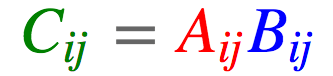

In [23]:
display.Image('../pics/einsum10.png')

In [24]:
a = torch.arange(6).reshape(2, 3)
b = torch.arange(6,12).reshape(2, 3)
print(a)
print(b)
print(torch.einsum('ij,ij->ij', [a, b]))

tensor([[0, 1, 2],
        [3, 4, 5]])
tensor([[ 6,  7,  8],
        [ 9, 10, 11]])
tensor([[ 0,  7, 16],
        [27, 40, 55]])


# 9 外积

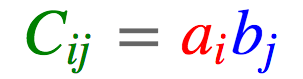

In [25]:
display.Image('../pics/einsum11.png')

In [26]:
a = torch.arange(3)
b = torch.arange(3,7)
print(a)
print(b)
print(torch.einsum('i,j->ij', [a, b]))

tensor([0, 1, 2])
tensor([3, 4, 5, 6])
tensor([[ 0,  0,  0,  0],
        [ 3,  4,  5,  6],
        [ 6,  8, 10, 12]])


# 10 batch 矩阵相乘

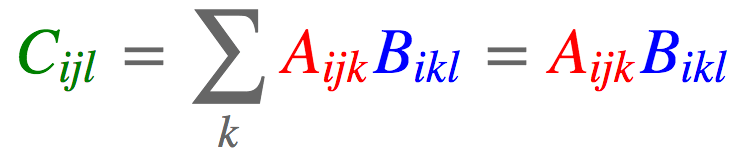

In [27]:
display.Image('../pics/einsum12.png')

In [28]:
a = torch.randn(3,2,5)
b = torch.randn(3,5,3)
print(a)
print(b)
print(torch.einsum('ijk,ikl->ijl', [a, b]))

tensor([[[ 1.7472, -1.2841,  1.0421,  0.6256,  0.4265],
         [-1.2643,  0.9666, -0.5454,  0.0822,  1.0358]],

        [[-0.0775, -1.2047,  1.5029, -0.3362,  0.7608],
         [ 2.1545, -1.4327,  0.5353,  0.5834, -1.1785]],

        [[-1.1164,  0.4177, -1.9266,  1.2698,  0.6060],
         [-1.2696,  0.6566,  0.9307,  0.1137, -0.6567]]])
tensor([[[ 0.6725,  0.4079, -0.4548],
         [ 0.6524, -0.3525,  1.2395],
         [-0.9683,  0.1404, -0.4171],
         [ 0.5207,  0.3088,  0.0460],
         [ 1.2499,  0.4482,  0.9566]],

        [[-0.5624,  0.4729,  0.6844],
         [ 0.3450,  0.6867, -1.2037],
         [ 0.0215, -1.4017, -0.7371],
         [ 2.1671, -0.2785,  0.8387],
         [-0.8384,  0.0952, -0.8133]],

        [[ 1.4210, -2.2699,  0.4636],
         [ 2.0214,  0.5295,  0.8563],
         [ 0.3191,  0.0552,  0.4357],
         [ 0.5550,  0.7018, -1.3192],
         [-0.7441, -0.5553, -0.3388]]])
tensor([[[ 0.1870,  1.6959, -2.3841],
         [ 1.6458, -0.4433,  2.9953]],

    

In [29]:
a = torch.randn(3,2,5)
b = torch.randn(3,5,3)
print(a)
print(b)
print(torch.einsum('ijk,ikl->ijl', [a, b]))

tensor([[[-0.6598,  0.4136, -0.4351,  0.4289, -0.2109],
         [ 0.9673,  0.6882,  0.0891,  1.0107, -0.7718]],

        [[ 0.6230, -0.8627, -0.3057,  0.2273,  0.0072],
         [-1.2046,  0.3446, -0.7899, -2.6244,  1.2953]],

        [[-0.4206, -0.5502, -1.9856, -2.2151,  0.5195],
         [ 1.3084,  0.7056, -0.0604, -0.0984,  0.0334]]])
tensor([[[ 0.4559, -2.4534,  0.2964],
         [-0.8747,  1.1481,  0.4832],
         [-0.1080,  0.0811, -0.7059],
         [ 2.7496, -1.0097, -1.3815],
         [ 0.1072,  0.5245, -1.4894]],

        [[ 0.5069,  0.5378, -1.1083],
         [-1.1594, -0.8331,  0.1087],
         [-1.2776,  0.4482, -1.1194],
         [ 2.1996,  2.1670,  1.0803],
         [-0.3683, -0.1466,  0.7310]],

        [[ 0.5516, -1.4926,  1.9509],
         [-0.9681,  1.9026,  0.4313],
         [-0.6476, -0.7795, -1.0361],
         [ 0.6921, -0.5724, -0.0467],
         [-0.9715,  0.7135,  1.7061]]])
tensor([[[ 0.5410,  1.5146,  0.0330],
         [ 2.5255, -3.0012,  0.3096]],

    

# 11 张量缩约

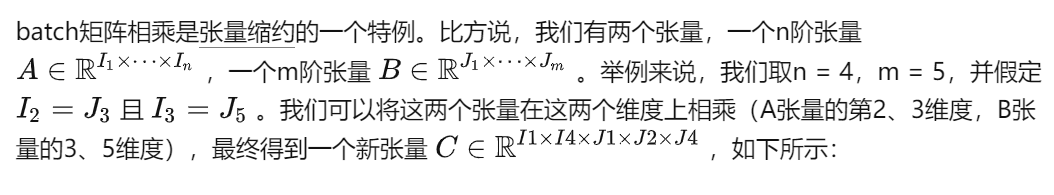

In [30]:
display.Image('../pics/einsum14.png')

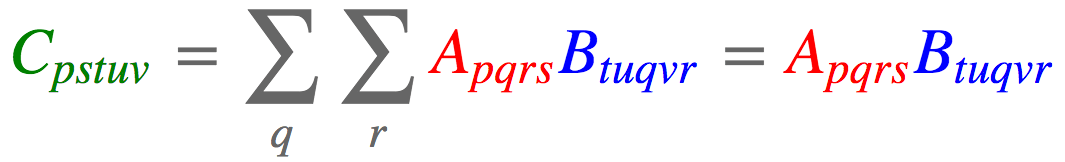

In [31]:
display.Image('../pics/einsum13.png')

In [32]:
a = torch.randn(2,3,5,7)
b = torch.randn(11,13,3,17,5)
torch.einsum('pqrs,tuqvr->pstuv', [a, b]).shape

torch.Size([2, 7, 11, 13, 17])

In [33]:
print(a)
print(b)
print(torch.einsum('pqrs,tuqvr->pstuv', [a, b]))

tensor([[[[ 0.4608, -0.8503,  1.1434, -1.1495,  1.4854, -0.8429, -1.3225],
          [ 2.5518,  0.0903, -0.9389,  0.0859, -1.3519,  0.3024, -1.1633],
          [-0.9915, -0.5155, -1.4514,  0.0169,  0.6782, -0.9647, -1.7101],
          [-1.2767,  1.2952,  1.7812, -0.2219,  0.4122,  1.3793,  2.6374],
          [ 0.2444,  1.3675, -0.2009, -0.0707, -0.7891, -0.2379,  0.5683]],

         [[-0.1220, -0.5547, -0.0541, -0.8322,  1.0198,  0.9513, -0.0207],
          [-0.9297,  1.0220, -0.1353,  2.0853, -1.6905, -0.1176,  0.8796],
          [-0.0086, -0.9456,  0.0843, -1.5267, -0.0704, -1.5941,  0.5542],
          [-1.4131,  0.0913,  1.1642,  0.0628, -0.0856, -0.0325,  0.2939],
          [-0.1794,  0.6374,  0.4415, -0.9586, -1.2431,  1.1689,  1.0638]],

         [[-0.3529, -0.2976, -0.0831,  0.3683, -0.6957,  0.0177, -0.7162],
          [ 0.2178,  0.3760,  2.2024,  0.0239,  0.2308, -0.2095,  1.1229],
          [ 2.0577,  0.9173,  0.5474,  0.3160,  0.4068, -0.7924, -1.6030],
          [ 0.1607, -

# 12 双线性变换

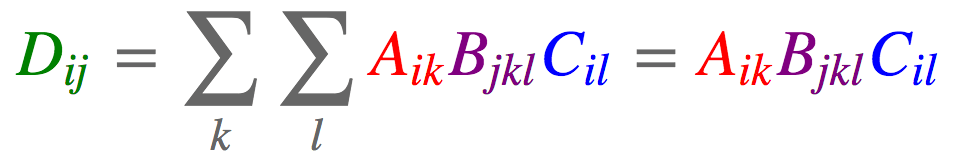

In [34]:
display.Image('../pics/einsum15.png')

In [35]:
a = torch.randn(2,3)
b = torch.randn(5,3,7)
c = torch.randn(2,7)
torch.einsum('ik,jkl,il->ij', [a, b, c])

tensor([[-1.0411, -0.9257, -0.2273,  3.1848, -0.3436],
        [-1.9731,  0.4220,  3.2177, -1.9372,  2.8153]])

# 其他案例

### 1TreeQN

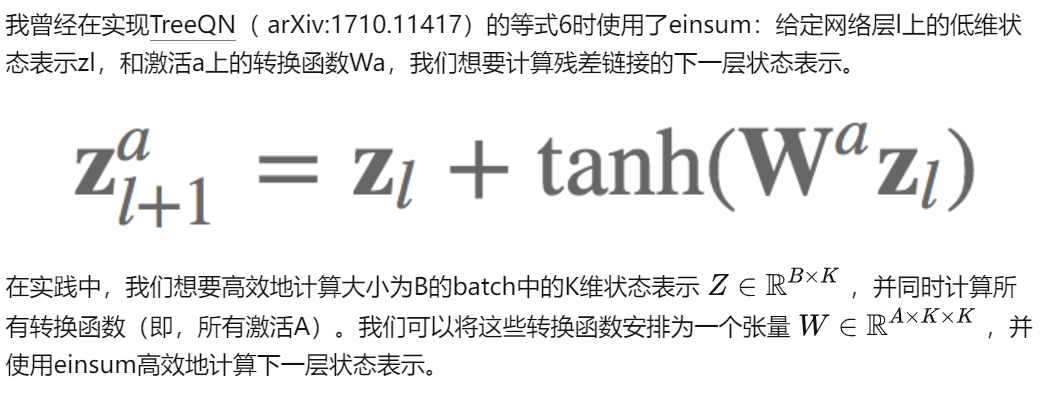

In [36]:
display.Image('../pics/einsum16.png')

In [37]:
import torch.nn.functional as F

def random_tensors(shape, num=1, requires_grad=False):
  tensors = [torch.randn(shape, requires_grad=requires_grad) for i in range(0, num)]
  return tensors[0] if num == 1 else tensors

# 参数
# -- [激活数 x 隐藏层维度]
b = random_tensors([5, 3], requires_grad=True)
# -- [激活数 x 隐藏层维度 x 隐藏层维度]
W = random_tensors([5, 3, 3], requires_grad=True)
print(b)
print(W)
zl = random_tensors([2, 3])
print(zl)

tensor([[-0.5426,  1.1368, -0.1992],
        [-0.5014, -2.2054,  1.0608],
        [-0.9334,  2.1414, -1.3026],
        [ 0.7785, -0.5098, -0.0147],
        [ 0.1172,  0.8308, -0.3981]], requires_grad=True)
tensor([[[ 0.0423, -2.5183, -1.7754],
         [ 0.2519,  0.3001, -0.9720],
         [-1.6496, -0.1412,  0.3735]],

        [[ 0.4044, -0.0244,  0.7421],
         [ 0.0988,  0.1183, -0.9462],
         [ 1.0474, -0.0650,  1.2527]],

        [[ 0.7466, -0.6504,  0.2956],
         [ 0.6422,  0.2846, -0.9657],
         [-1.4987,  0.3439, -1.1111]],

        [[-1.5468, -0.9301, -0.4109],
         [-2.2095, -1.1450, -1.2434],
         [ 2.3392,  1.0539, -0.4120]],

        [[-0.3645,  0.4431,  0.1449],
         [-2.7522,  1.8604,  0.9688],
         [-0.3645, -0.6637, -0.8134]]], requires_grad=True)
tensor([[ 0.8550, -0.3328, -1.0981],
        [-0.0736,  0.3208,  0.7306]])


In [38]:
torch.einsum("bk,aki->bai", [zl, W]).shape

torch.Size([2, 5, 3])

In [39]:

def transition(zl):
    # -- [batch大小 x 激活数 x 隐藏层维度]
    return zl.unsqueeze(1) + F.tanh(torch.einsum("bk,aki->bai", [zl, W]) + b)

# 随机取样仿造输入
# -- [batch大小 x 隐藏层维度]


transition(zl)

C:\Users\lenovo\.conda\envs\CLMLF\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([[[ 1.6949, -1.0775, -2.0453],
         [-0.0164, -1.3082, -0.5370],
         [ 1.6684,  0.4724, -0.6427],
         [-0.1280, -1.3021, -0.6358],
         [ 1.6631,  0.5339, -0.8099]],

        [[-1.0051,  1.1864,  0.6234],
         [ 0.1861, -0.6555,  1.6549],
         [-1.0278,  1.3083, -0.2545],
         [ 0.8820,  0.2821,  0.1362],
         [-0.8374,  1.0421,  0.1312]]], grad_fn=<AddBackward0>)

### 2 Attention

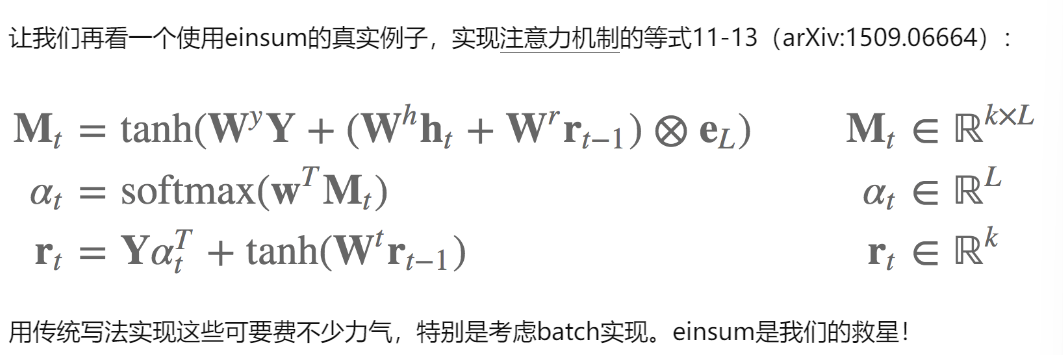

In [40]:
display.Image('../pics/einsum17.png')

In [41]:
# 参数
# -- [隐藏层维度]
bM, br, w = random_tensors([7], num=3, requires_grad=True)
# -- [隐藏层维度 x 隐藏层维度]
WY, Wh, Wr, Wt = random_tensors([7, 7], num=4, requires_grad=True)

# 注意力机制的单次应用
def attention(Y, ht, rt1):
    # -- [batch大小 x 隐藏层维度]
    tmp = torch.einsum("ik,kl->il", [ht, Wh]) + torch.einsum("ik,kl->il", [rt1, Wr])
    Mt = F.tanh(torch.einsum("ijk,kl->ijl", [Y, WY]) + tmp.unsqueeze(1).expand_as(Y) + bM)
    # -- [batch大小 x 序列长度]
    at = F.softmax(torch.einsum("ijk,k->ij", [Mt, w]))
    # -- [batch大小 x 隐藏层维度]
    rt = torch.einsum("ijk,ij->ik", [Y, at]) + F.tanh(torch.einsum("ij,jk->ik", [rt1, Wt]) + br)
    # -- [batch大小 x 隐藏层维度], [batch大小 x 序列维度]
    return rt, at

# 取样仿造输入
# -- [batch大小 x 序列长度 x 隐藏层维度]
Y = random_tensors([3, 5, 7])
# -- [batch大小 x 隐藏层维度]
ht, rt1 = random_tensors([3, 7], num=2)

rt, at = attention(Y, ht, rt1)

C:\Users\lenovo\.conda\envs\CLMLF\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
